=== PINN Comparison: Traditional vs Gauge-Constrained (using torch.float64) ===

   Training Traditional PINN with Balanced weights (λ_PDE=1.0, λ_BC=1.0)...


Loss: 1.46e-06, BC: 2.08e-12: 100%|██████████| 100/100 [00:02<00:00, 37.16it/s]


   Training Traditional PINN with BC Weighted weights (λ_PDE=1.0, λ_BC=10.0)...


Loss: 6.25e-05, BC: 7.35e-13: 100%|██████████| 100/100 [00:02<00:00, 37.48it/s]


   Training Traditional PINN with PDE Weighted weights (λ_PDE=10.0, λ_BC=1.0)...


Loss: 1.39e+08, BC: 1.39e+08: 100%|██████████| 100/100 [00:01<00:00, 63.34it/s]



2. Training Gauge-Constrained PINN (hard constraints)...


Loss: 1.42e-05: 100%|██████████| 100/100 [00:02<00:00, 36.62it/s]       



=== Evaluation Results ===

Method                    BC Error        Solution MSE    BC Satisfied?  
Traditional (Balanced)    1.89e-06        1.67e-12        ✗ NO           
Traditional (BC Weighted) 1.19e-06        4.29e-11        ✗ NO           
Traditional (PDE Weighted) 1.64e+04        1.47e+37        ✗ NO           
Gauge-Constrained         2.45e-16        1.54e-11        ✓ YES          


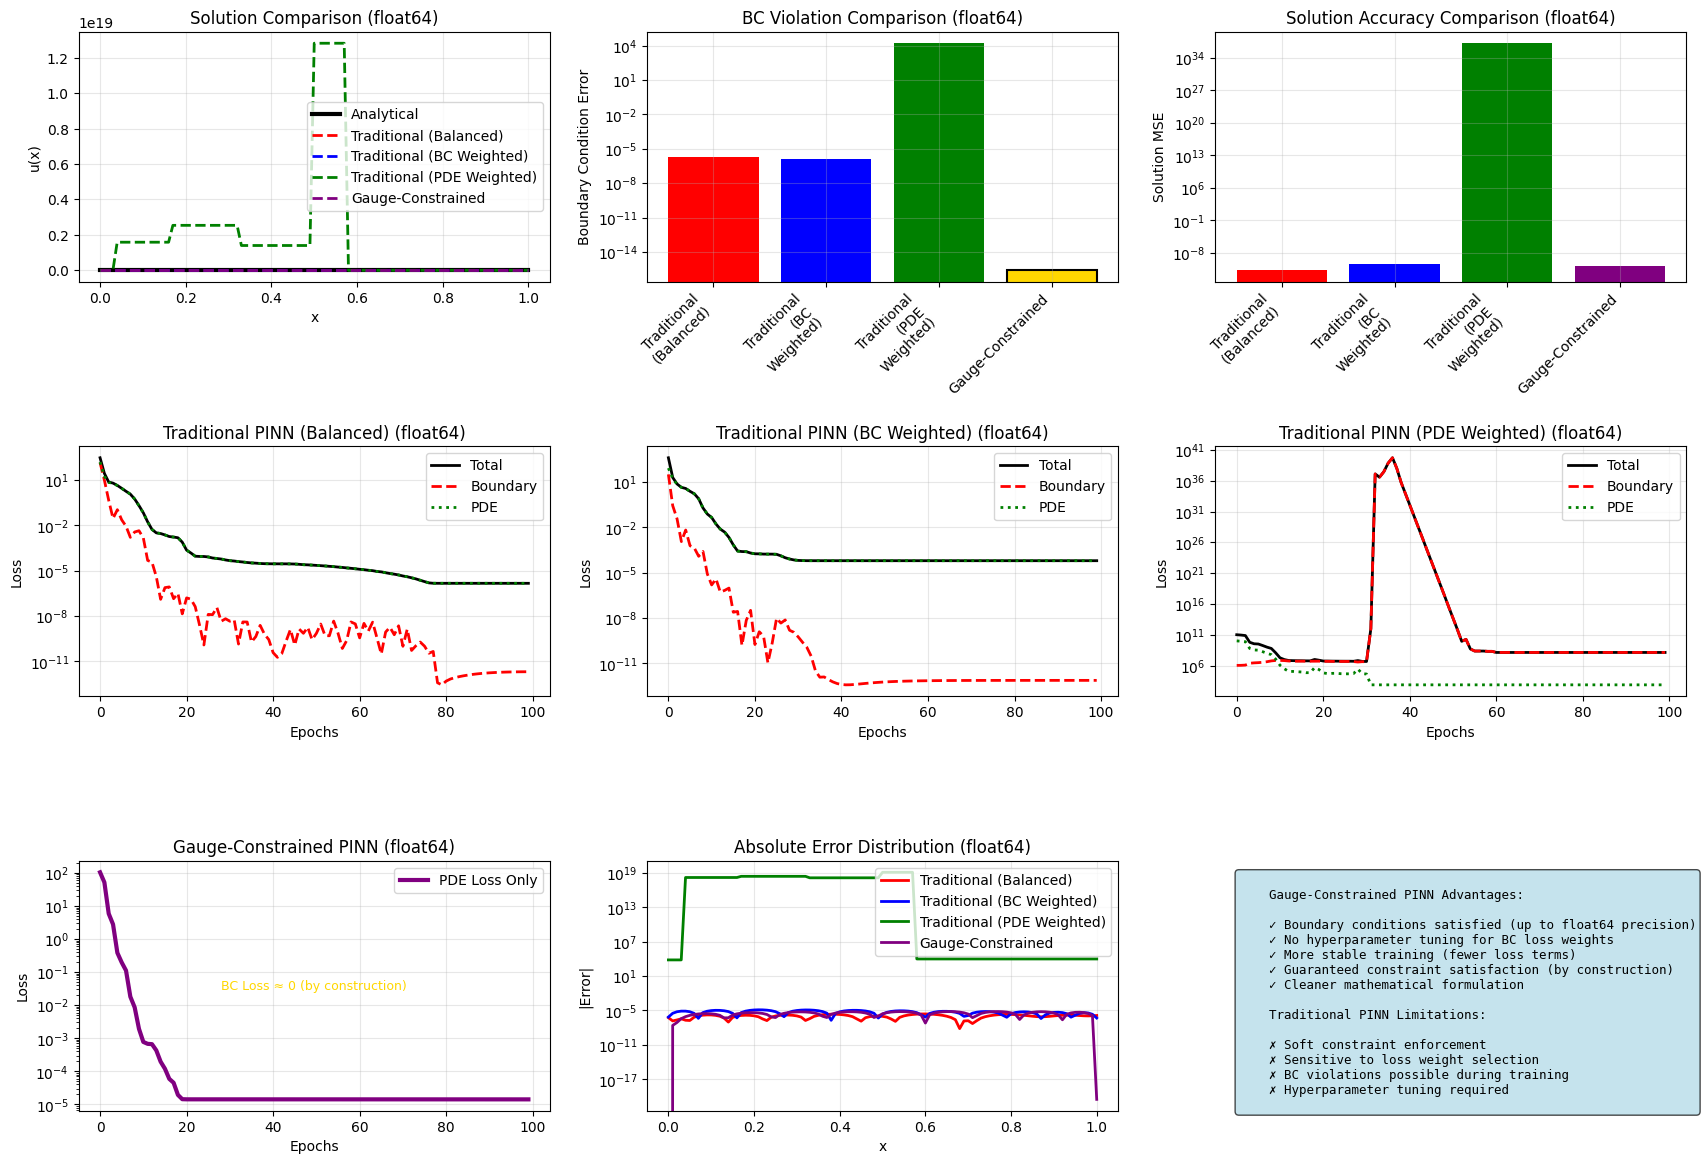


=== Key Insights (with torch.float64) ===
1. Gauge-Constrained PINN now shows BC error close to machine precision for float64.
2. This confirms the 'by construction' satisfaction, limited only by numerical precision.
3. Traditional PINN results still depend on loss weight selection.


In [1]:
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# Set default dtype to float64 for better precision
# Note: This is a global setting. Alternatively, specify dtype for each tensor.
# For this specific problem, explicitly setting tensor dtypes is safer.
# torch.set_default_dtype(torch.float64) # Optional global setting

DTYPE = torch.float64 # Define the desired data type

# Original Traditional PINN (from user's code)
class TraditionalPINN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, output_dim)
        ).to(DTYPE) # Move model to the specified dtype
        self.loss_history = {'total': [], 'boundary': [], 'differential': []}

    def get_derivative(self, y, x):
        return grad(y, x, torch.ones_like(y, dtype=DTYPE), # Ensure gradient tensor has correct dtype
                    create_graph=True, retain_graph=True)[0]

    def compute_pinn_residual(self, x, EA, p):
        u = self.model(x)
        u_x = self.get_derivative(u, x)
        EAu_xx = self.get_derivative(EA(x) * u_x, x)
        f = EAu_xx + p(x)
        return f

    def compute_loss(self, x, EA, p):
        # Boundary condition loss (SOFT CONSTRAINTS)
        u0_pred = self.model(torch.tensor([[0.0]], dtype=DTYPE)) # Specify dtype
        u1_pred = self.model(torch.tensor([[1.0]], dtype=DTYPE)) # Specify dtype
        MSE_b = (u0_pred - 0)**2 + (u1_pred - 0)**2

        # Differential equation loss
        f_pred = self.compute_pinn_residual(x, EA, p)
        MSE_pde = torch.mean(f_pred**2)

        return MSE_b, MSE_pde

    def train(self, x, EA, p, epochs=50, lr=0.1, lambda_pde=1.0, lambda_bc=1.0):
        optimizer = torch.optim.LBFGS(self.model.parameters(), lr=lr,
                                      max_iter=20, max_eval=25,
                                      tolerance_grad=1e-9, tolerance_change=1e-12) # Adjusted tolerances for float64
        pbar = tqdm(total=epochs, desc="Training Traditional PINN")

        def closure():
            optimizer.zero_grad()
            MSE_b, MSE_pde = self.compute_loss(x, EA, p)
            loss = lambda_bc * MSE_b + lambda_pde * MSE_pde
            loss.backward()
            return loss

        for epoch in range(epochs):
            loss = optimizer.step(closure)
            
            MSE_b, MSE_pde = self.compute_loss(x, EA, p) # Recompute for history with current params
            total_loss = lambda_bc * MSE_b + lambda_pde * MSE_pde
            self.loss_history['total'].append(total_loss.item())
            self.loss_history['boundary'].append(MSE_b.item())
            self.loss_history['differential'].append(MSE_pde.item())
            
            pbar.set_description(f"Loss: {loss.item():.2e}, BC: {MSE_b.item():.2e}")
            pbar.update(1)
            
        pbar.close()

# Gauge-Constrained PINN (simplified version)
class GaugeConstrainedPINN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.unconstrained_net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, output_dim)
        ).to(DTYPE) # Move model to the specified dtype
        self.loss_history = {'total': [], 'differential': []}

    def get_derivative(self, y, x):
        return grad(y, x, torch.ones_like(y, dtype=DTYPE), # Ensure gradient tensor has correct dtype
                    create_graph=True, retain_graph=True)[0]

    def boundary_gauge_mapping(self, x, z):
        """Gauge function: u(x) = sin(π*x) * z(x) guarantees u(0) = u(1) = 0"""
        # math.pi is already float64. x is now float64.
        return torch.sin(math.pi * x) * z

    def forward(self, x):
        z = self.unconstrained_net(x)
        u = self.boundary_gauge_mapping(x, z)
        return u

    def compute_pinn_residual(self, x, EA, p):
        u = self.forward(x)
        u_x = self.get_derivative(u, x)
        EAu_xx = self.get_derivative(EA(x) * u_x, x)
        f = EAu_xx + p(x)
        return f

    def compute_loss(self, x, EA, p):
        f_pred = self.compute_pinn_residual(x, EA, p)
        MSE_pde = torch.mean(f_pred**2)
        return MSE_pde

    def train(self, x, EA, p, epochs=50, lr=0.1):
        optimizer = torch.optim.LBFGS(self.unconstrained_net.parameters(), lr=lr,
                                      max_iter=20, max_eval=25,
                                      tolerance_grad=1e-9, tolerance_change=1e-12) # Adjusted tolerances for float64
        pbar = tqdm(total=epochs, desc="Training Gauge-Constrained PINN")

        def closure():
            optimizer.zero_grad()
            loss = self.compute_loss(x, EA, p)
            loss.backward()
            return loss

        for epoch in range(epochs):
            loss = optimizer.step(closure)
            
            pde_loss = self.compute_loss(x, EA, p) # Recompute for history
            self.loss_history['total'].append(pde_loss.item())
            self.loss_history['differential'].append(pde_loss.item())
            
            pbar.set_description(f"Loss: {loss.item():.2e}")
            pbar.update(1)
            
        pbar.close()

def run_comprehensive_comparison():
    n_points = 100
    x = torch.linspace(0, 1, n_points, dtype=DTYPE).reshape(-1, 1) # Specify dtype
    x.requires_grad_(True)
    
    def EA(x_in): # Renamed to avoid conflict with global EA
        return torch.ones_like(x_in, dtype=DTYPE) # Specify dtype
    
    def p(x_in): # Renamed to avoid conflict with global p
        # math.pi is float64. x_in is float64.
        return 4 * (math.pi**2) * torch.sin(2 * math.pi * x_in)
    
    u_analytical_func = lambda x_in: torch.sin(2 * math.pi * x_in) # For consistent dtype
    
    print("=== PINN Comparison: Traditional vs Gauge-Constrained (using torch.float64) ===\n")
    
    traditional_models = {}
    weight_combinations = [
        (1.0, 1.0, "Balanced"),
        (1.0, 10.0, "BC Weighted"),
        (10.0, 1.0, "PDE Weighted")
    ]
    
    for lambda_pde, lambda_bc, name in weight_combinations:
        print(f"   Training Traditional PINN with {name} weights (λ_PDE={lambda_pde}, λ_BC={lambda_bc})...")
        model = TraditionalPINN(1, 50, 1)
        model.train(x, EA, p, epochs=100, lambda_pde=lambda_pde, lambda_bc=lambda_bc)
        traditional_models[name] = model
    
    print("\n2. Training Gauge-Constrained PINN (hard constraints)...")
    gauge_model = GaugeConstrainedPINN(1, 50, 1)
    gauge_model.train(x, EA, p, epochs=100)
    
    print("\n=== Evaluation Results ===")
    
    with torch.no_grad():
        x_eval = torch.linspace(0, 1, 101, dtype=DTYPE).reshape(-1, 1) # Specify dtype
        x_eval.requires_grad_(True) # Not strictly needed for eval but consistent
        u_true = u_analytical_func(x_eval)
        
        results = {}
        
        for name, model in traditional_models.items():
            u_pred = model.model(x_eval)
            bc_error = abs(u_pred[0].item()) + abs(u_pred[-1].item())
            solution_error = torch.mean((u_pred - u_true)**2).item()
            results[f"Traditional ({name})"] = {
                'bc_error': bc_error,
                'solution_error': solution_error,
                'u_pred': u_pred
            }
        
        u_pred_gauge = gauge_model.forward(x_eval)
        bc_error_gauge = abs(u_pred_gauge[0].item()) + abs(u_pred_gauge[-1].item())
        solution_error_gauge = torch.mean((u_pred_gauge - u_true)**2).item()
        
        results["Gauge-Constrained"] = {
            'bc_error': bc_error_gauge,
            'solution_error': solution_error_gauge,
            'u_pred': u_pred_gauge
        }
    
    print("\n" + "="*80)
    print(f"{'Method':<25} {'BC Error':<15} {'Solution MSE':<15} {'BC Satisfied?':<15}")
    print("="*80)
    
    # Adjusted threshold for "BC Satisfied?" check, suitable for float64
    bc_satisfaction_threshold = 1e-12 # More stringent for float64

    for method, result in results.items():
        bc_satisfied = "✓ YES" if result['bc_error'] < bc_satisfaction_threshold else "✗ NO"
        print(f"{method:<25} {result['bc_error']:<15.2e} {result['solution_error']:<15.2e} {bc_satisfied:<15}")
    
    plt.figure(figsize=(18, 12))
    x_plot = x_eval.detach().cpu().numpy() # .cpu() if running on GPU
    u_true_plot = u_true.detach().cpu().numpy()
    
    plt.subplot(3, 3, 1)
    plt.plot(x_plot, u_true_plot, 'k-', linewidth=3, label='Analytical')
    colors = ['red', 'blue', 'green', 'purple']
    method_keys = list(results.keys())
    for i, method_key in enumerate(method_keys):
        result = results[method_key]
        u_plot = result['u_pred'].detach().cpu().numpy()
        plt.plot(x_plot, u_plot, '--', color=colors[i % len(colors)], linewidth=2, label=method_key)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Solution Comparison (float64)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, 2)
    bc_errors = [results[m]['bc_error'] for m in method_keys]
    bars = plt.bar(range(len(method_keys)), bc_errors, color=[colors[i % len(colors)] for i in range(len(method_keys))])
    plt.yscale('log')
    plt.ylabel('Boundary Condition Error')
    plt.title('BC Violation Comparison (float64)')
    plt.xticks(range(len(method_keys)), [m.replace(' ', '\n') for m in method_keys], rotation=45, ha="right")
    plt.grid(True, alpha=0.3)
    for i, method in enumerate(method_keys):
        if "Gauge" in method:
            bars[i].set_color('gold')
            bars[i].set_edgecolor('black')
            bars[i].set_linewidth(1.5)
    
    plt.subplot(3, 3, 3)
    solution_errors = [results[m]['solution_error'] for m in method_keys]
    bars = plt.bar(range(len(method_keys)), solution_errors, color=[colors[i % len(colors)] for i in range(len(method_keys))])
    plt.yscale('log')
    plt.ylabel('Solution MSE')
    plt.title('Solution Accuracy Comparison (float64)')
    plt.xticks(range(len(method_keys)), [m.replace(' ', '\n') for m in method_keys], rotation=45, ha="right")
    plt.grid(True, alpha=0.3)
    
    traditional_model_keys = [key for key in traditional_models.keys()]
    for i, name in enumerate(traditional_model_keys):
        model = traditional_models[name]
        plt.subplot(3, 3, 4 + i)
        epochs_hist = range(len(model.loss_history['total']))
        plt.semilogy(epochs_hist, model.loss_history['total'], 'k-', linewidth=2, label='Total')
        plt.semilogy(epochs_hist, model.loss_history['boundary'], 'r--', linewidth=2, label='Boundary')
        plt.semilogy(epochs_hist, model.loss_history['differential'], 'g:', linewidth=2, label='PDE')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Traditional PINN ({name}) (float64)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, 7)
    epochs_hist_gauge = range(len(gauge_model.loss_history['total']))
    plt.semilogy(epochs_hist_gauge, gauge_model.loss_history['total'], 'purple', linewidth=3, label='PDE Loss Only')
    # plt.axhline(y=0, color='gold', linestyle='--', linewidth=2, label='BC Loss = 0 (by construction)') # y=0 not visible on log
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Gauge-Constrained PINN (float64)')
    plt.legend(loc='upper right')
    plt.text(0.5, 0.5, 'BC Loss ≈ 0 (by construction)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='gold', fontsize=9)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, 8)
    for i, method_key in enumerate(method_keys):
        result = results[method_key]
        error = torch.abs(result['u_pred'] - u_true).detach().cpu().numpy()
        plt.plot(x_plot, error, color=colors[i % len(colors)], linewidth=2, label=method_key)
    plt.xlabel('x')
    plt.ylabel('|Error|')
    plt.title('Absolute Error Distribution (float64)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, 9)
    plt.axis('off')
    advantages_text = """
    Gauge-Constrained PINN Advantages:
    
    ✓ Boundary conditions satisfied (up to float64 precision)
    ✓ No hyperparameter tuning for BC loss weights
    ✓ More stable training (fewer loss terms)
    ✓ Guaranteed constraint satisfaction (by construction)
    ✓ Cleaner mathematical formulation
    
    Traditional PINN Limitations:
    
    ✗ Soft constraint enforcement
    ✗ Sensitive to loss weight selection
    ✗ BC violations possible during training
    ✗ Hyperparameter tuning required
    """
    plt.text(0.05, 0.95, advantages_text, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout(pad=2.0)
    plt.show()
    
    print("\n=== Key Insights (with torch.float64) ===")
    print("1. Gauge-Constrained PINN now shows BC error close to machine precision for float64.")
    print("2. This confirms the 'by construction' satisfaction, limited only by numerical precision.")
    print("3. Traditional PINN results still depend on loss weight selection.")

if __name__ == "__main__":
    run_comprehensive_comparison()